In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

Brownian motion simulation

In [4]:
def Brownian_Simulation(t):
  n = len(t)
  T = t[-1]
  dt = T/n
  W = np.zeros(n)
  for i in range(1,n):
      inc = np.sqrt(dt)*np.random.normal(0,1)
      W[i] = W[i-1]+inc
  return W

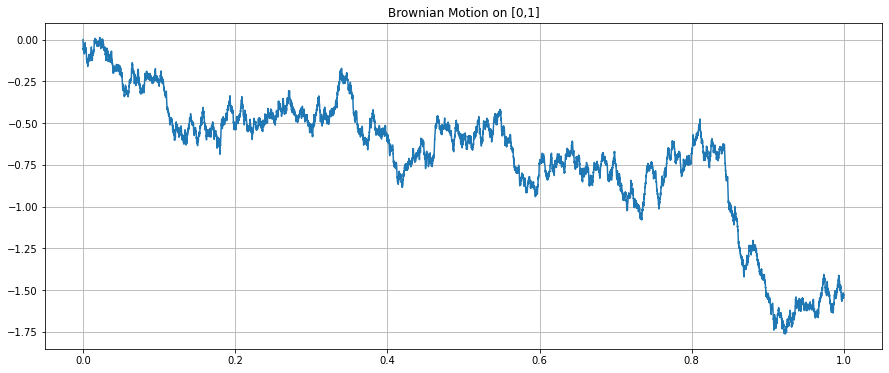

In [5]:
n = 10000
T = 1

t =  np.linspace(0,T,n)

W = Brownian_Simulation(t)

plt.figure(figsize=(15,6))
plt.title("Brownian Motion on [0,1]")
plt.plot(t,W)
plt.grid()
plt.show()

Stock price simulation (Monte-Carlo)

In [6]:
# Underlying Stock Price at t=0
S0 = 100
# Strike Price:
K = 100
# Risk Free Rate : 
r = 0.05
# Volatility :
sigma = 0.2

Single stock price simulation

In [7]:
def Stock_Price_Sim_Unit(S0, sigma, r, t):
  W = Brownian_Simulation(t)
  S = S0 * np.exp((r - 0.5*sigma**2)*t + sigma*W)
  return S

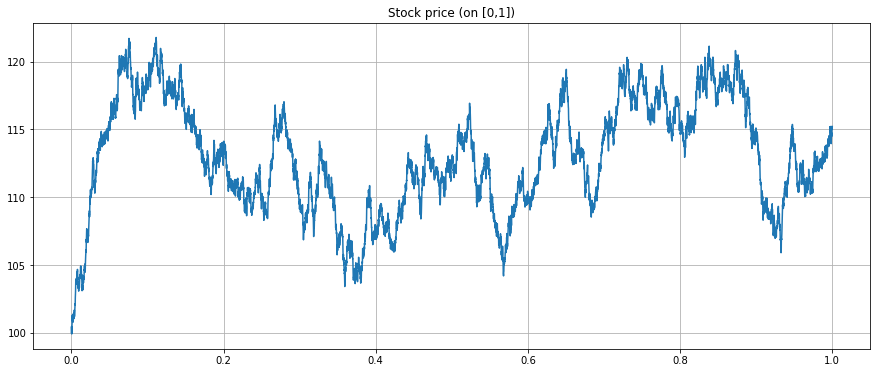

In [8]:
# T : Maturity in year
T = 1
# Nb of subdivisions of [0,T]
n=10000
# Time line (linspace)
t =  np.linspace(0,T,n)

S = Stock_Price_Sim_Unit(S0, sigma, r, t)

plt.figure(figsize=(15,6))
plt.title("Stock price (on [0,1])")
plt.plot(t,S)
plt.grid()
plt.show()

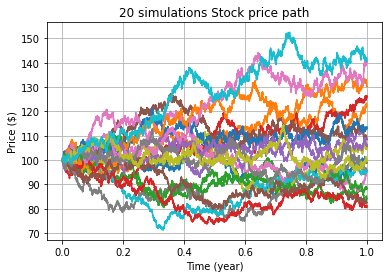

In [10]:
# T : Maturity in year
T = 1
# Nb of subdivisions of [0,T]
n=10000
# Time line (linspace)
t =  np.linspace(0,T,n)

plt.figure()
plt.grid()
plt.title('20 simulations Stock price path')
for i in range(20):
  S = Stock_Price_Sim_Unit(S0, sigma, r, t)
  plt.plot(t,S, label='Path '+str(i+1))

plt.xlabel('Time (year)')
plt.ylabel('Price ($)')
plt.show()

Stock price simulation

In [11]:
def Stock_Price_Sim(nb_iter, S0, sigma, r, t):
  n = len(t)
  sim = np.zeros((nb_iter, n))
  for i in range(nb_iter):
    sim[i,:] = Stock_Price_Sim_Unit(S0, sigma, r, t)
  S_sim = np.mean(sim, axis=0)
  return S_sim

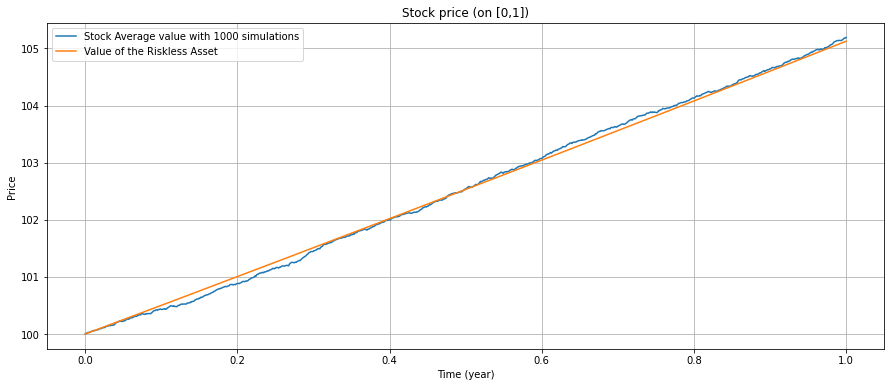

In [12]:
# T : Maturity in year
T = 1
# Nb of subdivisions of [0,T]
n=1000
# Time line (linspace)
t =  np.linspace(0,T,n)
# Nb Monte-Carlo simulations :
nb_iter = 10000
vec=S0*np.exp(r*t)
SP_sim = Stock_Price_Sim(nb_iter, S0, sigma, r, t)

plt.figure(figsize=(15,6))
plt.title("Stock price (on [0,1])")
plt.plot(t,SP_sim, label='Stock Average value with 1000 simulations')
plt.plot(t,vec, label='Value of the Riskless Asset')
plt.xlabel('Time (year)')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Call price simulation

In [13]:
def Stock_Terminal_Value(St, t, T, r, sigma):
  return St*np.exp(sigma*np.sqrt(T-t)*np.random.normal(0,1) + (r - 0.5*sigma**2)*(T-t))

In [14]:
def Call_Payoff(S, K):
  return max(S - K,0)

In [15]:
def Call_Price_MC(St, t, T, r, sigma, K, nb_iter):
  sim = np.zeros(nb_iter)
  for i in range(nb_iter):
    sim[i] = Call_Payoff(Stock_Terminal_Value(St, t, T, r, sigma), K)*np.exp(-r*(T-t))
  S_sim = np.mean(sim)
  return S_sim

Arbitrage pricing

In [16]:
# Nb Monte-Carlo simulations :
nb_iter = 1000000

Call_Price = Call_Price_MC(S0, 0, T, r, sigma, K, nb_iter)
print(f"Monte-Carlo simulated European Call price (Strike ${K}): ${Call_Price}")

Monte-Carlo simulated European Call price (Strike $100): $10.442694733531848


Black-Scholes Formula

In [17]:
# Cumulative dstribution function of the standard normal distribution N(0,1)
def N(d):
  return norm.cdf(d)

def d1(x, K, r, sigma, t, T):
    num = np.log(x/K) + (r+0.5*sigma**2)*(T-t)
    denom = sigma * np.sqrt(T-t)
    return num/denom

def d2(x, K, r, sigma, t, T):
  return d1(x, K, r, sigma, t, T) - sigma*np.sqrt(T-t)

#Black-Scholes Formula
def F(x, K, r, sigma, t, T):
  return x * N(d1(x, K, r, sigma, t, T)) - K * np.exp(-r*(T-t)) * N(d2(x, K, r, sigma, t, T))

In [18]:
def Pricing_process(S, sigma, r, t, K):
  n = len(S)
  P = np.zeros(n)
  for i in range(n-1):
    P[i] = F(S[i], K, r, sigma, t[i], t[-1])
  P[-1] = Call_Payoff(S[-1], K)
  return P

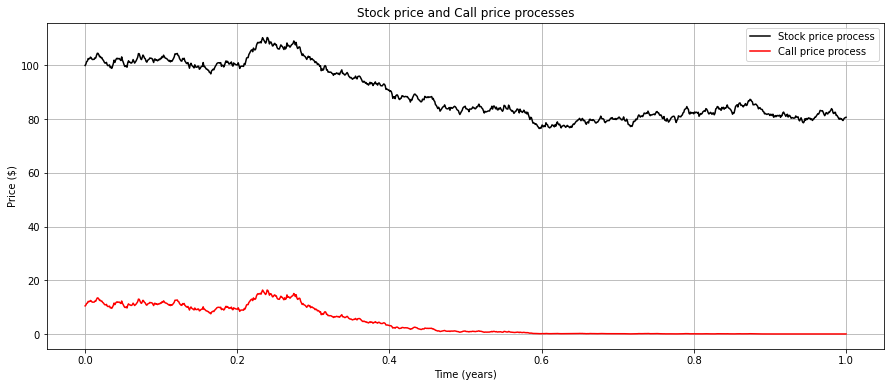

In [19]:
# T : Maturity in year
T = 1
# Nb of subdivisions of [0,T]
n=1000
# Time line (linspace)
t =  np.linspace(0,T,n)

Stock_Price_process = Stock_Price_Sim_Unit(S0, sigma, r, t)

Call_Price_process  = Pricing_process(Stock_Price_process, sigma, r, t, K)

plt.figure(figsize=(15,6))
plt.title("Stock price and Call price processes")
plt.plot(t,Stock_Price_process, label="Stock price process", color='k')
plt.plot(t,Call_Price_process, label="Call price process", color='r')
plt.xlabel('Time (years)')
plt.ylabel('Price ($)')
plt.grid()
plt.legend()
plt.show()

Price simulation convergence check

In [20]:
print("Option type: European")
print("Option: Call")
print(f"Initial spot price: ${S0}")
print(f"Strike price: ${K}")
print("Time interval: [0,1] \n")

BS_Call_Pricing = F(S0, K, r, sigma, 0, T)

# Nb Monte-Carlo simulations :
nb_iter = 1000000

MC_Call_Pricing = Call_Price_MC(S0, 0, T, r, sigma, K, nb_iter)

print(f"Option price from Black-Scholes formula: ${np.round(BS_Call_Pricing,3)}\n")

print(f"Option price from Monte-Carlo simulations: ${np.round(MC_Call_Pricing,3)}\n")

Option type: European
Option: Call
Initial spot price: $100
Strike price: $100
Time interval: [0,1] 

Option price from Black-Scholes formula: $10.451

Option price from Monte-Carlo simulations: $10.458



Call Hedging

Hedging ratio $\,\pi_t = \frac{\partial F}{\partial x}(t,S_t)$, then $(p_0, \pi)$ replicates $V(S_T)$.

From computations done in the article, we derive that: $\,\pi_t = \frac{\partial F}{\partial x}(t,S_t) = N(d_1(S_t))$.

In [21]:
def Hedging_process(S, sigma, r, t, K):
  n = len(S)
  # Hedging process
  H = np.zeros(n-1)
  # Associated wealth process
  X = np.zeros(n)
  # Portfolio initialization
  X[0] = F(S[0], K, r, sigma, t[0], t[-1])
  for i in range(n-1):
    H[i] = N(d1(S[i], K, r, sigma, t[i], t[-1]))
    X[i+1] = H[i]*S[i+1] + (X[i] - H[i]*S[i])*np.exp(r*(t[i+1]-t[i]))
  return H, X

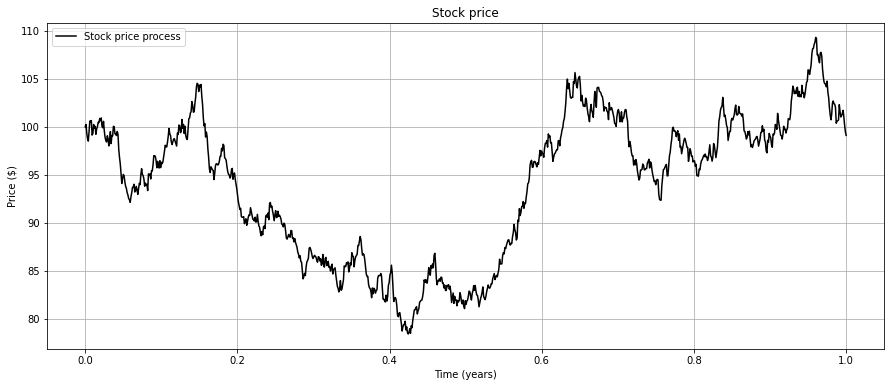

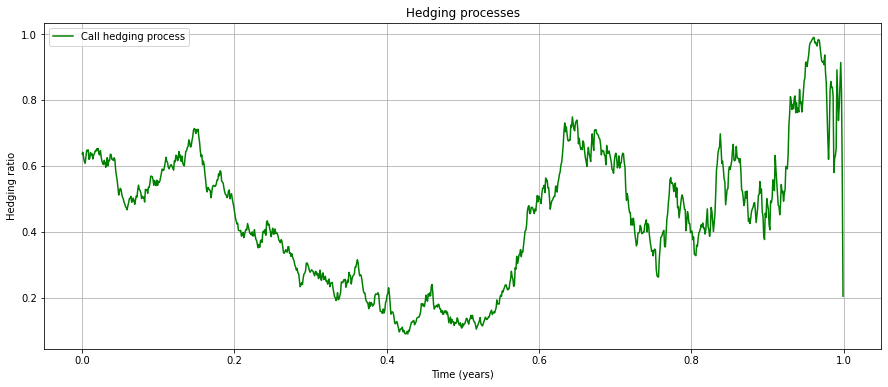

In [22]:
# T : Maturity in year
T = 1
# Nb of subdivisions of [0,T]
n=1000
# Time line (linspace)
t =  np.linspace(0,T,n)

Stock_Price_process = Stock_Price_Sim_Unit(S0, sigma, r, t)

Call_Price_process  = Pricing_process(Stock_Price_process, sigma, r, t, K)

Call_Hedging_process, Replicating_Portfolio = Hedging_process(Stock_Price_process, sigma, r, t, K)

plt.figure(figsize=(15,6))
plt.title("Stock price")
plt.plot(t,Stock_Price_process, label="Stock price process", color='k')
plt.xlabel('Time (years)')
plt.ylabel('Price ($)')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
plt.title("Hedging processes")
plt.plot(t[:-1],Call_Hedging_process, label="Call hedging process", color='g')
plt.xlabel('Time (years)')
plt.ylabel('Hedging ratio')
plt.grid()
plt.legend()
plt.show()

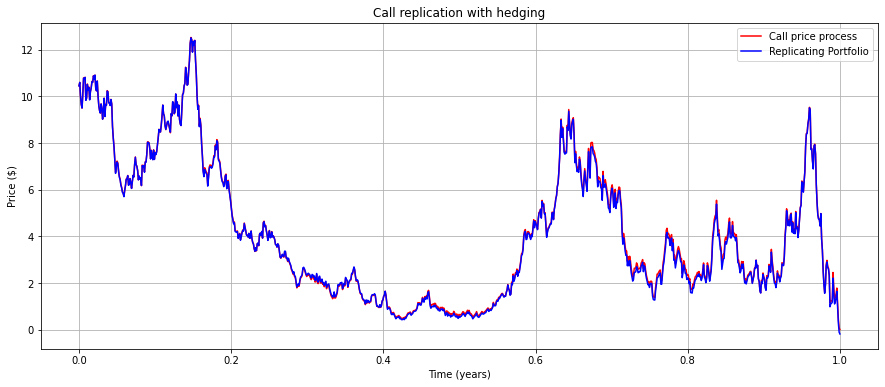

In [23]:
plt.figure(figsize=(15,6))
plt.title("Call replication with hedging")
plt.plot(t,Call_Price_process, label="Call price process", color='r')
plt.plot(t,Replicating_Portfolio, label="Replicating Portfolio", color='b')
plt.xlabel('Time (years)')
plt.ylabel('Price ($)')
plt.grid()
plt.legend()
plt.show()